In [1]:
#imports
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam
from functions.ep_optimizers import EpochEVE_allparams
#from functions.eve_optimizer import GD_EVE, GD_EVE_mb, GD_EVE2_mb, GD_EVE2_allparams_mb, GD_EVE_mb_shuff, GD_EVE2_mb_shuff, EpochEVE, EpochEVE2, EpochEVE3

In [2]:
#DDplus imports
#imitating "RunModel_Tracks_to_KDE_Iter17_DDplus_24Jan2021_loss_Ba_moreData"
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model
#from model.models_kde import TracksToKDE_Ellipsoids_Skipper as Model

from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [3]:
num_epochs = 60
# Size of batches
batch_size = 24 ## batch_size = 24 ---> 4763MiB / 12066MiB on Titan V
# How fast to learn
lr = 1.5e-5

betas = (0.9, 0.999)

In [4]:
!nvidia-smi

Thu Aug 26 22:09:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    23W / 250W |   5124MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [5]:
device = 'cuda:1'

In [6]:
## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_data = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                  #'/share/lazy/will/data/June30_2020_80k_2.h5',
                                  #'/share/lazy/will/data/June30_2020_80k_3.h5',
                                  #'/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPwU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                          device=device,
                          slice = slice(None,60000)
                           )

EVE_data = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                  #'/share/lazy/will/data/June30_2020_80k_2.h5',
                                  #'/share/lazy/will/data/June30_2020_80k_3.h5',
                                  #'/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPwU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                          device=device,
                          slice = slice(60000,None)
                           )

# train_data_eval = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
#                                   #'/share/lazy/will/data/June30_2020_80k_2.h5',
#                                   #'/share/lazy/will/data/June30_2020_80k_3.h5',
#                                   #'/share/lazy/will/data/June30_2020_80k_4.h5',
#                              batch_size=batch_size,
# ## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
# ## the dataset will overflow the GPU memory; device=device will allow the data to move back
# ## and forth between the CPU and GPwU memory. While this allows use of a larger dataset, it slows
# ## down performance by about 10%.  So comment out when not needed.
#                           device=device,
# ##                           slice = slice(None,18000)
#                           shuffle=False
#                            )

# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,

## For iter12, change slice(18000,None) to slice(10000,None)
## First, we'll see if this changes the validation cost significantly
##  Second, we will see if this reduces the validation cost fluctuations
test_data = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            #slice = slice(10000,None)
                           )

Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

len(X) =  80000
len(Xlist) =  1
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 300.8 s
outer loop X.shape =  (80000, 9, 600)
Constructing 20000 event dataset took 1.539 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t.shape =  torch.Size([20000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -1

In [7]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model.to(device)
loss_fn = Loss(epsilon=3e-5)

In [8]:
param_states = []
train_losses = []
train_mode_losses = []
#train_accs = []
test_losses = []
#test_accs = []
step_scalars = []
ep_times = []
adam_step_sizes = []

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    step_sizes = []
    model.train()
    #total_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        g, m1, m2, step_size = optimizer.step()
        step_sizes.append(step_size)

    return step_sizes

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    return test_loss/len(dataloader)

In [10]:
#Choose optimizer
optimizer = Adam(model.parameters(), lr=lr, betas=betas)
ep_optimizer = EpochEVE_allparams(model.parameters(), model, loss_fn, EVE_data, device)

#getting initial param state
param_states.append(get_param_state(model))

#Getting initial train and test loss
l = test(train_data, model, loss_fn)
train_losses.append(l)
#train_accs.append(a)
l = test(test_data, model, loss_fn)
test_losses.append(l)
#test_accs.append(a)

#initial time is 0
ep_times.append(0)

#epoch index
total_time = 0
j = 0
while j < num_epochs:
#while total_time < time_lim:
    start_time = time.time()
    print(' - Epoch: %i'%(j+1))

    #run minibatch optimizer
    these_adam_step_sizes = train(train_data, model, loss_fn, optimizer)
    print("Adam took", time.time()-start_time, 's')
    
    #apply epoch optimizer
    if ep_optimizer is not None:
        these_step_scalars = ep_optimizer.step()
    print('Epoch took',time.time()-start_time ,'s')
        
    total_time += time.time()-start_time
    #get metrics and parameter states of model after this epoch
    if ep_optimizer is not None:
        step_scalars.append(these_step_scalars)
    ep_times.append(total_time)
    adam_step_sizes = adam_step_sizes + these_adam_step_sizes
    param_states.append(get_param_state(model))
    
    l = test(train_data, model, loss_fn)
    train_losses.append(l)
    #train_accs.append(a)
    
    l = test(test_data, model, loss_fn)
    test_losses.append(l)
    #test_accs.append(a)

    j += 1
    
param_states = np.asarray(param_states)
steps = param_states[1:] - param_states[:-1]    

# step_scalars.append(this_step_scalars)
# train_losses.append(np.array(this_train_loss))
# test_losses.append(np.array(this_test_loss))
# test_acc.append(np.array(this_test_acc))
# train_times.append(np.array(this_train_times))
# test_times.append(np.array(this_test_times))
# param_states.append(np.array(this_param_states))

 - Epoch: 1
Adam took 314.81925415992737 s
Epoch took 442.6028127670288 s
 - Epoch: 2
Adam took 185.07911133766174 s
Epoch took 269.67962980270386 s
 - Epoch: 3
Adam took 190.62088084220886 s
Epoch took 275.9024920463562 s
 - Epoch: 4
Adam took 186.07908749580383 s
Epoch took 271.55434918403625 s
 - Epoch: 5
Adam took 188.0422158241272 s
Epoch took 273.48245549201965 s
 - Epoch: 6
Adam took 188.56410932540894 s
Epoch took 274.3127908706665 s
 - Epoch: 7
Adam took 188.28279519081116 s
Epoch took 273.504784822464 s
 - Epoch: 8
Adam took 189.7123157978058 s
Epoch took 275.1509006023407 s
 - Epoch: 9
Adam took 186.76106905937195 s
Epoch took 272.2189381122589 s
 - Epoch: 10
Adam took 187.86073303222656 s
Epoch took 272.9105803966522 s
 - Epoch: 11
Adam took 189.576740026474 s
Epoch took 275.06592535972595 s
 - Epoch: 12
Adam took 188.9936647415161 s
Epoch took 274.7032332420349 s
 - Epoch: 13
Adam took 189.51188349723816 s
Epoch took 278.40497279167175 s
 - Epoch: 14
Adam took 230.41806745

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


step scalars: [[0], [1], [1], [2], [0], [1], [1], [0], [4], [0], [4], [0], [2], [0], [4], [0], [2], [0], [4], [0], [4], [0], [2], [0], [4], [0], [2], [0], [2], [0], [2], [0], [2], [4], [0], [2], [0], [2], [2], [1], [0], [0.5], [1], [0], [0], [1], [1], [0], [1], [1], [1], [1], [0.5], [0], [2], [0], [1], [0], [1], [0]]


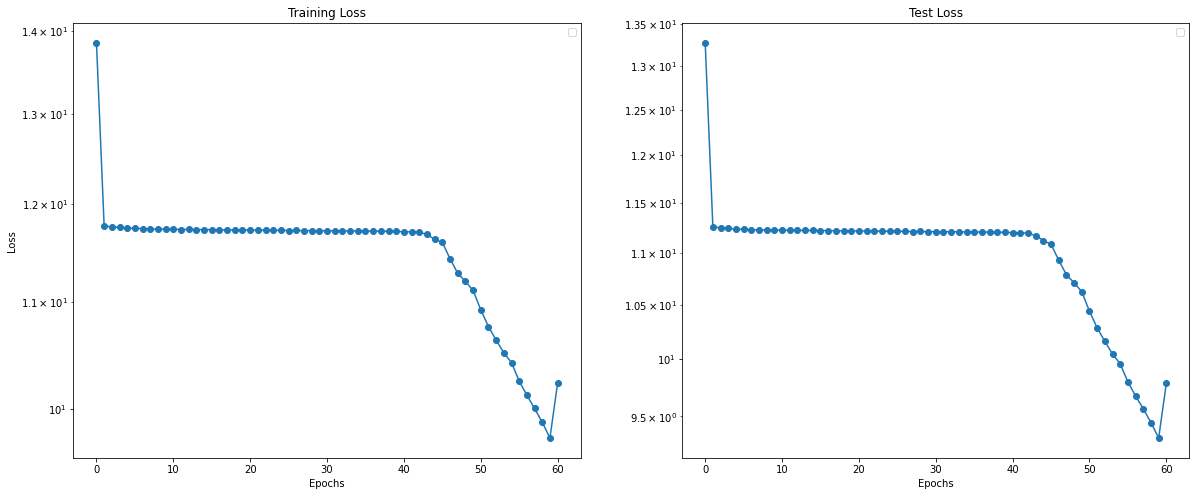

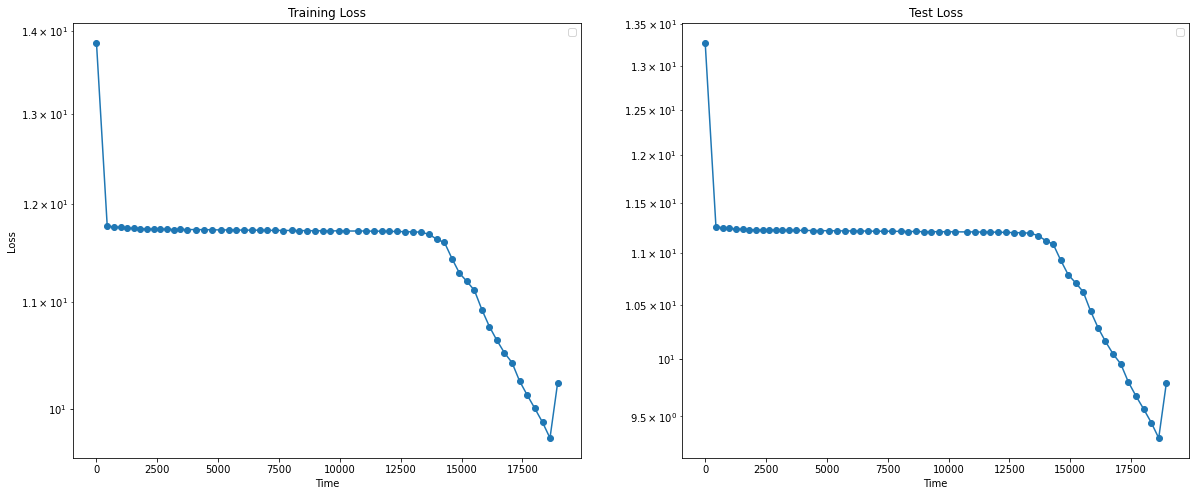

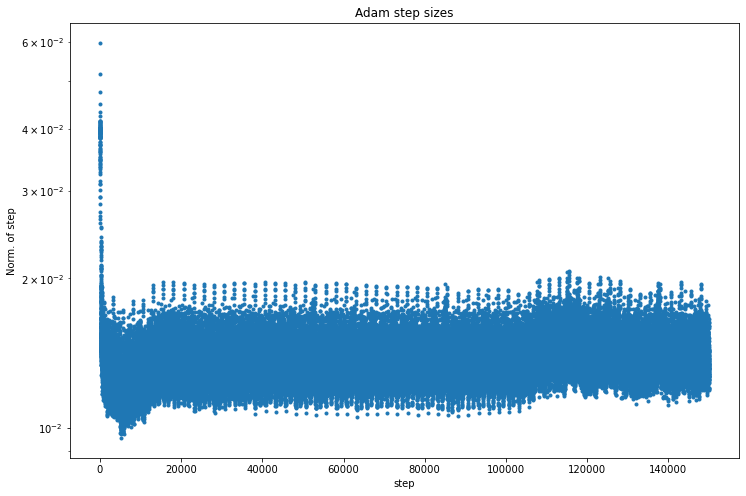

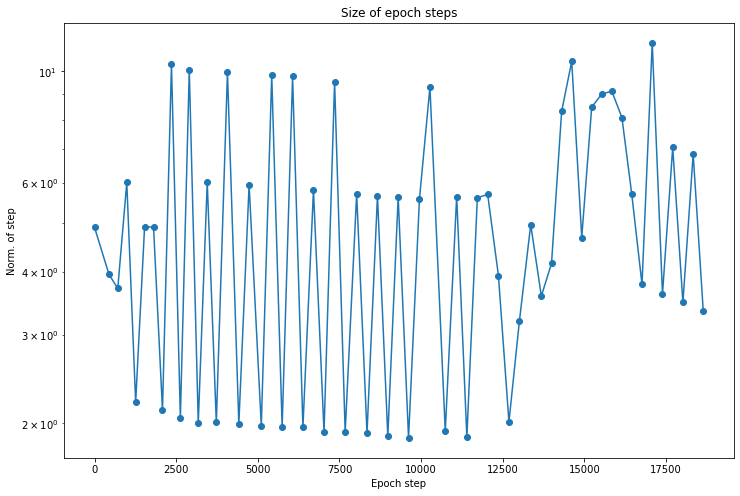

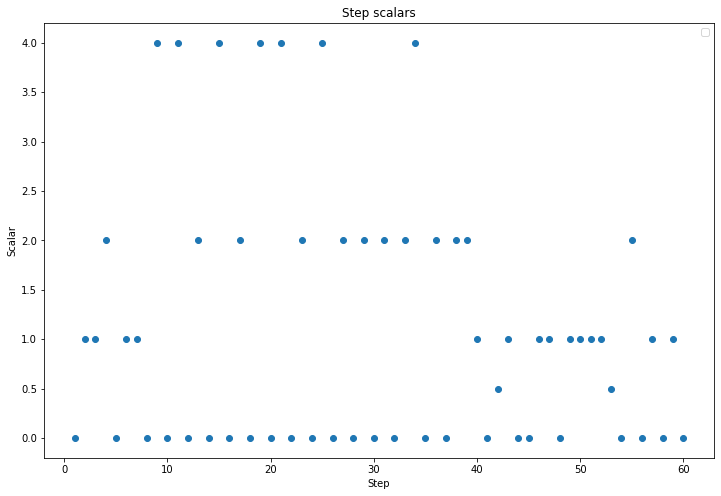

In [11]:
#plotting loss over training
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.plot(train_losses, 'o-')#, label=trial_labels[trial], color=trial_colors[trial])
plt.legend()
#plotting loss over testing
plt.subplot(1, 2, 2)
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.plot(test_losses, 'o-')#, label=trial_labels[trial], color=trial_colors[trial])
plt.legend()
##########################################################

#plotting loss over training
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.yscale('log')
plt.plot(ep_times, train_losses, 'o-')#, label=trial_labels[trial], color=trial_colors[trial])
plt.legend()

#plotting loss over testing
plt.subplot(1, 2, 2)
plt.title('Test Loss')
plt.xlabel('Time')
plt.yscale('log')
plt.plot(ep_times, test_losses, 'o-')#, label=trial_labels[trial], color=trial_colors[trial])
plt.legend()

#plotting adam step sizes
plt.figure(figsize=(12,8))
plt.title("Adam step sizes")
plt.xlabel("step")
plt.ylabel("Norm. of step")
plt.yscale('log')
plt.plot(adam_step_sizes, '.')

#plotting size of epoch step
plt.figure(figsize=(12,8))
plt.title("Size of epoch steps")
plt.xlabel("Epoch step")
plt.ylabel("Norm. of step")
plt.yscale('log')
plt.plot(ep_times[:-1], [np.linalg.norm(step) for step in steps], 'o-')

#plotting step scalars over time
print('step scalars:', step_scalars)
plt.figure(figsize=(12,8))
if len(step_scalars) > 0:
    #plt.figure(figsize=(12,8))
    plt.title('Step scalars')
    plt.ylabel('Scalar')
    plt.xlabel('Step')
    plt.scatter([i+1 for i in range(len(step_scalars))], step_scalars)#, label=trial_labels[trial], c=[trial_colors[trial] for i in range(len(step_scalars[trial]))])
    plt.legend()

In [12]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss are self explanatory; train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss are self explanatory; train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

In [13]:
def angle_between(i, j, epoch_steps):
    if i == j:
        return 0
    else:
        #print(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))
        return np.arccos(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))

this_grid_size = len(param_states)-1
angle_grid = np.zeros((this_grid_size, this_grid_size))
for i in range(this_grid_size):
    for j in range(this_grid_size):
        angle_grid[i, j] = angle_between(i, j, epoch_steps = steps)

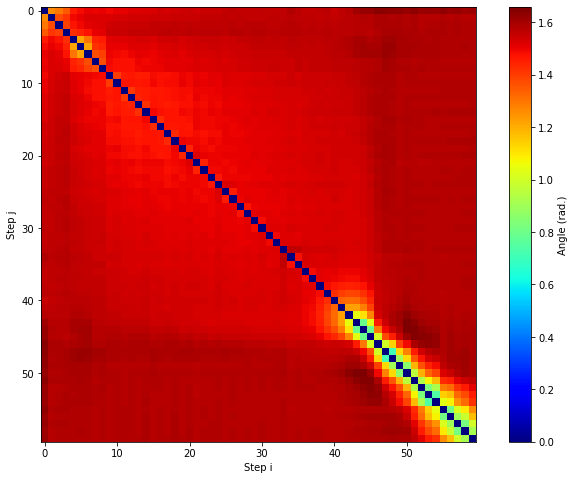

<Figure size 864x576 with 0 Axes>

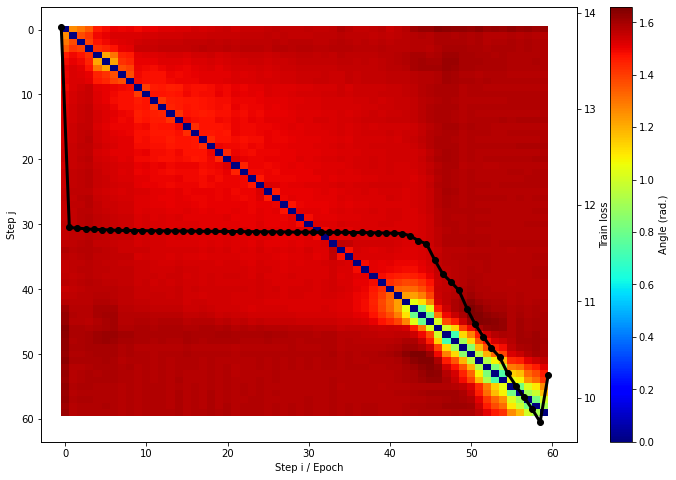

In [21]:
plt.figure(figsize=(12,8))

#norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   

plt.imshow(angle_grid, cmap=cm.jet)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
cbar.set_label('Angle (rad.)')
plt.xlabel('Step i')
plt.ylabel('Step j')

plt.figure(figsize=(12,8))

#norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))  
fig,ax = plt.subplots(figsize=(12,8))
#ax.set_ylabel("Training loss")
ax.set_xlabel("Epoch")
#plt.plot(train_losses, 'go-')
ax.imshow(angle_grid, cmap=cm.jet)
ax.set_ylim((num_epochs, 0))
ax2 = ax.twinx()
#ax.set_ylim((100, 0))
ax.set_aspect(0.80)
ax.set_ylabel('Step j')
ax2.set_ylabel('Train loss')
ax.set_xlabel("Step i / Epoch")
ax.set_xlim((-0.05*num_epochs, 1.05*num_epochs))
#ax.set_ylim((100, 0))
ax2.plot([i-0.5 for i in range(num_epochs+1)], train_losses, 'ko-', linewidth=3, markersize=6)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax)
cbar.set_label('Angle (rad.)')
# plt.xlabel('Step i')
# plt.ylabel('Step j')

In [15]:
from functions.plotting_DDplus_hists import load_data

state_dicts = []
for i in range(num_epochs):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


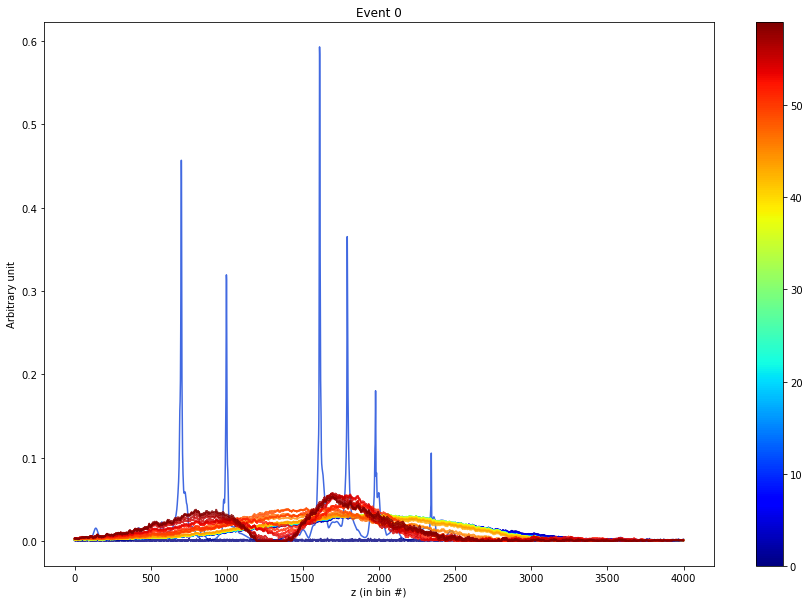

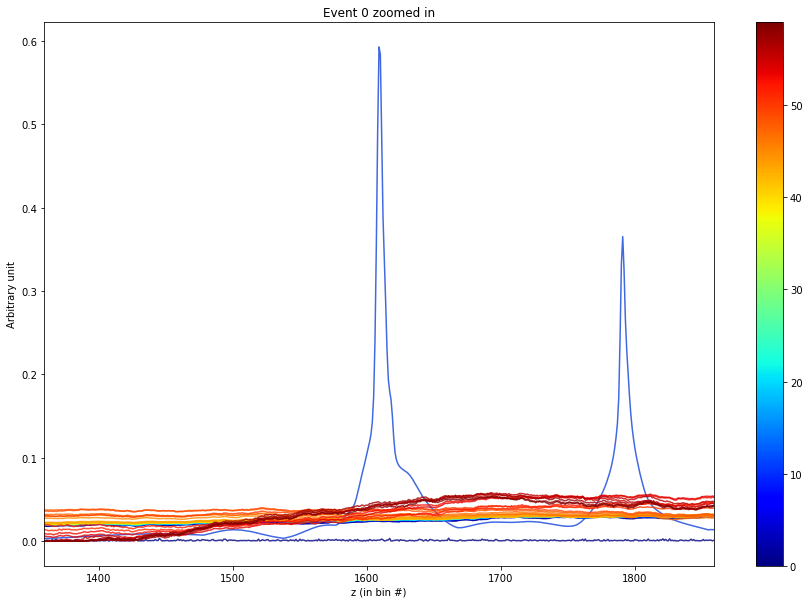

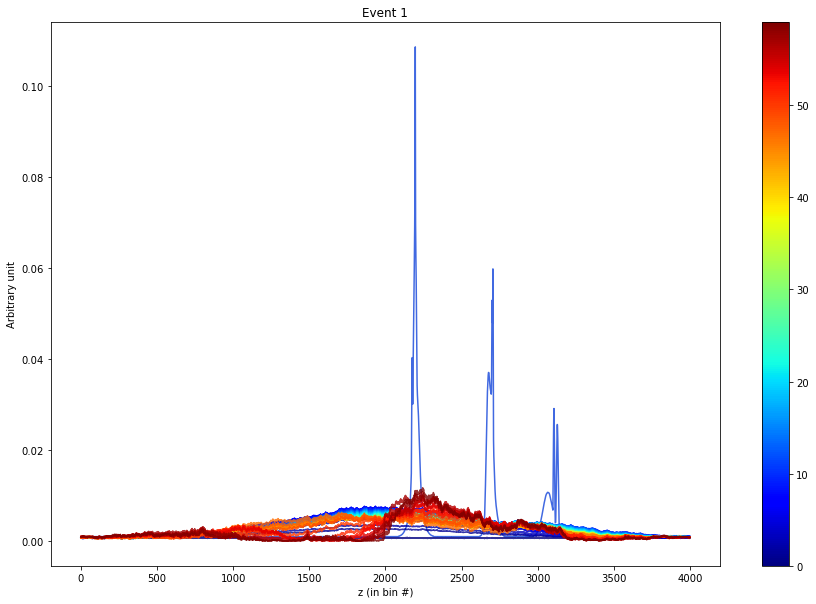

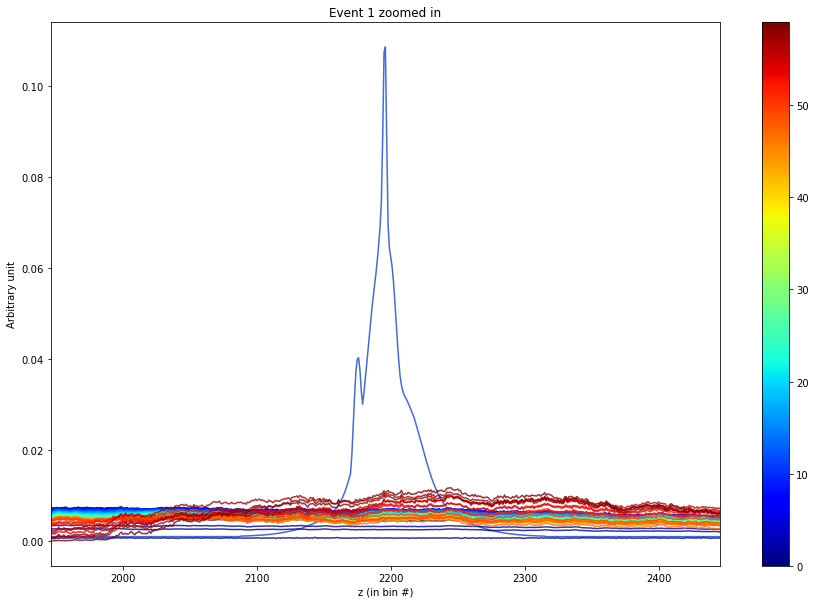

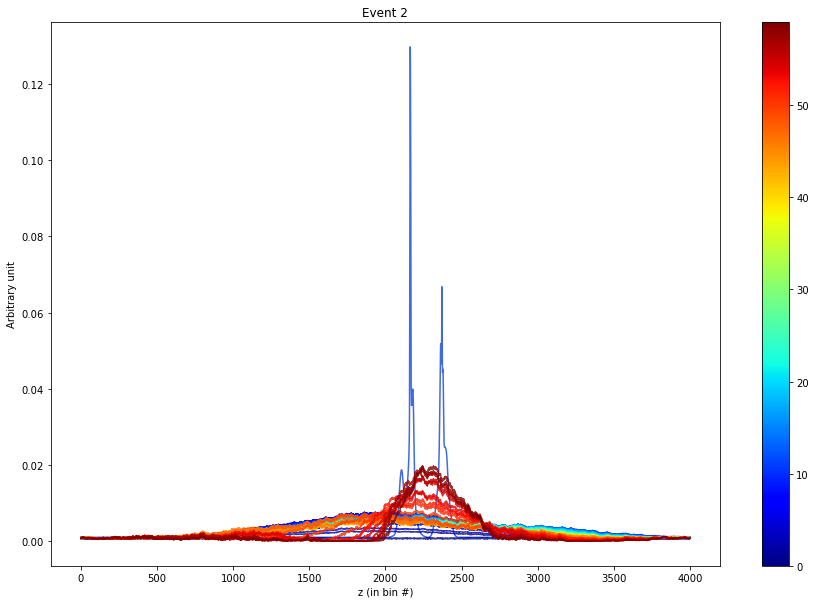

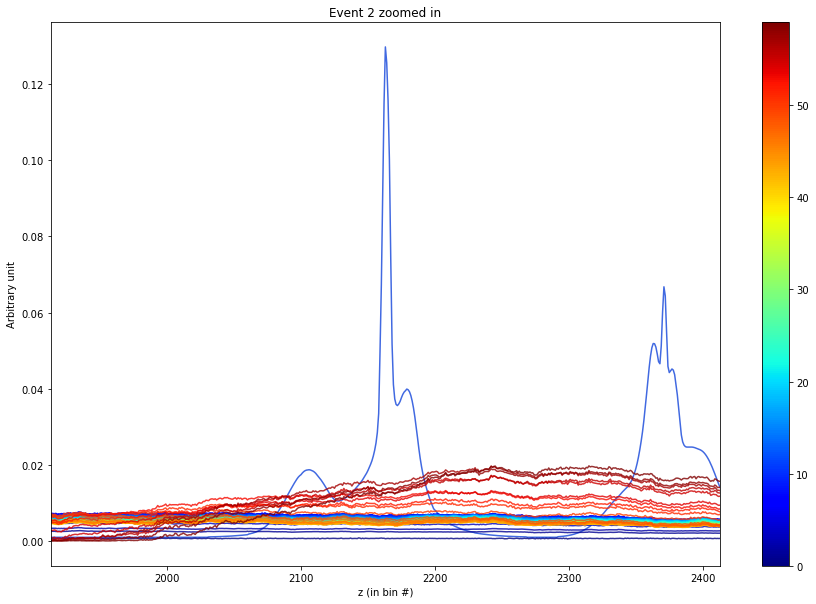

In [16]:
from functions.plotting_DDplus_hists import plot_DDplus_hists as Plot
Plot(state_dicts, data, num_events=3)

In [17]:
# #set shuffle to false, and recollect data to same variable avoid overloading GPU memory
# train_data = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
#                                   #'/share/lazy/will/data/June30_2020_80k_2.h5',
#                                   #'/share/lazy/will/data/June30_2020_80k_3.h5',
#                                   #'/share/lazy/will/data/June30_2020_80k_4.h5',
#                              batch_size=batch_size,
# ## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
# ## the dataset will overflow the GPU memory; device=device will allow the data to move back
# ## and forth between the CPU and GPwU memory. While this allows use of a larger dataset, it slows
# ## down performance by about 10%.  So comment out when not needed.
#                           device=device,
# ##                           slice = slice(None,18000)
#                           shuffle=False
#                            )

import time 
def scan_ahead(state_idx, num_steps=1, steps=[2**i for i in range(-2, 4)], epoch_states=param_states):
    losses = []
    for step in steps:
        #print(epoch_states[state_idx].shape, (epoch_states[state_idx+num_steps]-epoch_states[state_idx]).shape)
        time0 = time.time()
        param_state = epoch_states[state_idx] + step*(epoch_states[state_idx+num_steps]-epoch_states[state_idx])
        print('Calc. p. state took', time.time()-time0, 's')
        time0 = time.time()
        model.load_state_dict(vector_to_state_dict(param_state, model))
        print('Loading model state took', time.time()-time0, 's')
        time0 = time.time()
        this_loss = test(train_data, model, loss_fn)
        print('Calc. loss on training data took', time.time()-time0, 's')
        losses.append(this_loss)
    return steps, losses

colors = cm.magma(np.linspace(0, 1, len(np.arange(0, num_epochs-1, 5))))


scan_losses = []
scan_steps = []
for i in np.arange(0, num_epochs-1, 5):
    this_scan_steps, this_scan_losses = scan_ahead(i)
    scan_losses.append(this_scan_losses)
    scan_steps.append(this_scan_steps)
    

Calc. p. state took 0.164794921875 s
Loading model state took 0.04784083366394043 s
Calc. loss on training data took 42.1460177898407 s
Calc. p. state took 0.15852856636047363 s
Loading model state took 0.02382969856262207 s
Calc. loss on training data took 41.89161658287048 s
Calc. p. state took 0.15557074546813965 s
Loading model state took 0.028342723846435547 s
Calc. loss on training data took 41.77933740615845 s
Calc. p. state took 0.15449237823486328 s
Loading model state took 0.019233226776123047 s
Calc. loss on training data took 41.90902543067932 s
Calc. p. state took 0.170790433883667 s
Loading model state took 0.018107891082763672 s
Calc. loss on training data took 41.837050676345825 s
Calc. p. state took 0.15246295928955078 s
Loading model state took 0.01705455780029297 s
Calc. loss on training data took 42.470093727111816 s
Calc. p. state took 0.1555333137512207 s
Loading model state took 0.017697811126708984 s
Calc. loss on training data took 42.14048624038696 s
Calc. p. 

Calc. loss on training data took 42.078296184539795 s
Calc. p. state took 0.1524662971496582 s
Loading model state took 0.017784595489501953 s
Calc. loss on training data took 41.64034152030945 s
Calc. p. state took 0.15317606925964355 s
Loading model state took 0.01805710792541504 s
Calc. loss on training data took 41.731067419052124 s
Calc. p. state took 0.14916276931762695 s
Loading model state took 0.017460107803344727 s
Calc. loss on training data took 42.06539034843445 s
Calc. p. state took 0.15491485595703125 s
Loading model state took 0.03374361991882324 s
Calc. loss on training data took 42.3586208820343 s
Calc. p. state took 0.15113234519958496 s
Loading model state took 0.017068147659301758 s
Calc. loss on training data took 42.01861214637756 s
Calc. p. state took 0.1580982208251953 s
Loading model state took 0.0186307430267334 s
Calc. loss on training data took 42.05768966674805 s
Calc. p. state took 0.14932799339294434 s
Loading model state took 0.0321352481842041 s
Calc. 

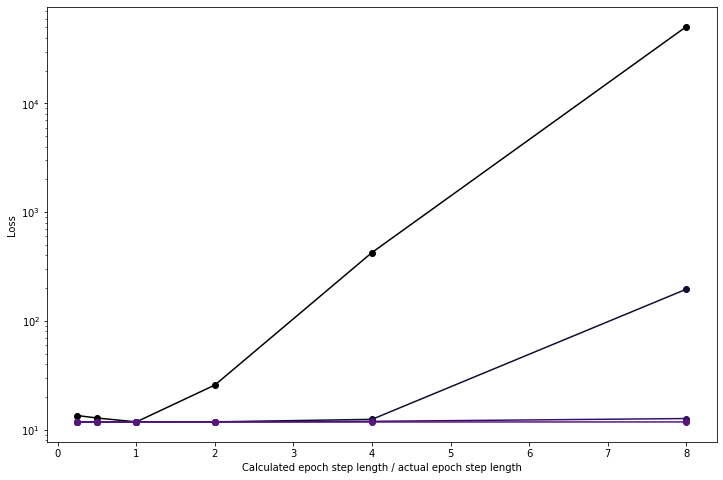

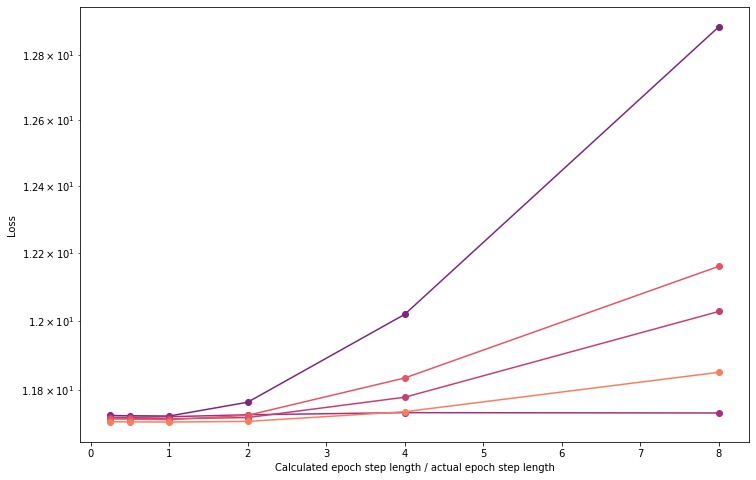

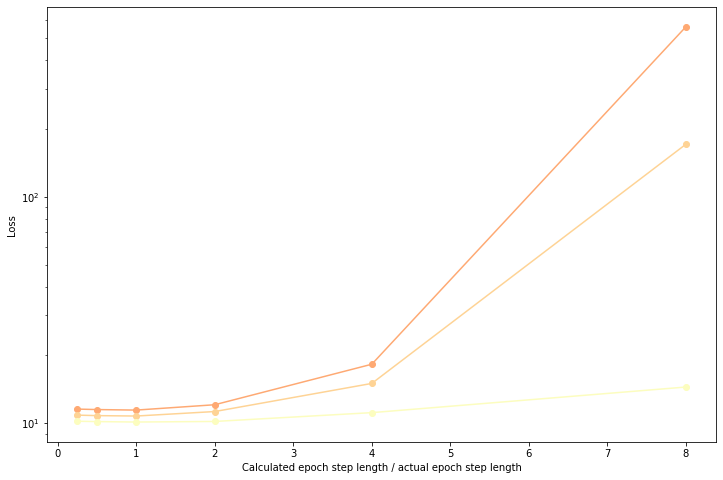

In [24]:
plt.figure(figsize=(12,8))
plt.xlabel('Calculated epoch step length / actual epoch step length')
plt.ylabel('Loss')
plt.yscale('log')
for i in range(len(np.arange(0, num_epochs-1, 5))):
    
    if (i+1) % 5 == 0:
        plt.figure(figsize=(12,8))
        plt.xlabel('Calculated epoch step length / actual epoch step length')
        plt.ylabel('Loss')
        plt.yscale('log')
        
    init_time = time.time()
    
    #print('time:', time.time()-init_time)
    plt.plot(scan_steps[i], scan_losses[i], 'o-', color=colors[i])